In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import math
import numpy as np

In [22]:
img = Image.open("../images/ren.jpg")

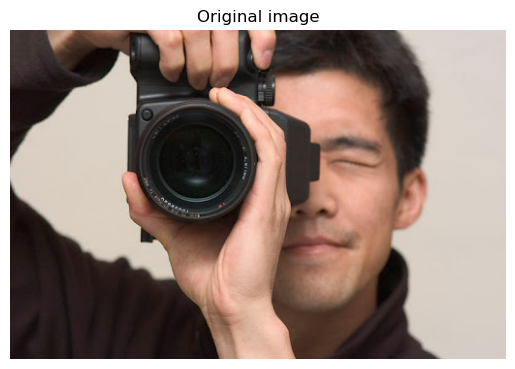

In [23]:
plt.imshow(img)
plt.axis('off')
plt.title("Original image")
plt.show()

### Code for Kuwahara filter below (could prob be optimized)

In [26]:
window_size = 8

# Convert to HSV and get NumPy array once
img = img.convert('HSV')
img_np = np.array(img)
height, width = img.height, img.width

# New image to store results
result = Image.new('HSV', (width, height))

# Size of each quadrant of a window
quadrant_size = math.ceil(window_size / 2)

for y in range(height):
    for x in range(width):
        tl_x = max(0, int(np.floor(x - (window_size / 2))))
        tl_y = max(0, int(np.floor(y - (window_size / 2))))
        mid_x = min(width, tl_x + quadrant_size)
        mid_y = min(height, tl_y + quadrant_size)
        wind_x = min(width, tl_x + window_size)
        wind_y = min(height, tl_y + window_size)

        # Extract quadrants
        quadrant_a = img_np[tl_y:mid_y, tl_x:mid_x]
        quadrant_b = img_np[tl_y:mid_y, mid_x:wind_x]
        quadrant_c = img_np[mid_y:wind_y, tl_x:mid_x]
        quadrant_d = img_np[mid_y:wind_y, mid_x:wind_x]

        quadrants = [quadrant_a, quadrant_b, quadrant_c, quadrant_d]

        # compute stdevs
        sigmas = []
        for q in quadrants:
            if q.size == 0:
                sigmas.append(np.inf)
            else:
                sigmas.append(np.std(q[:, :, 2]))

        # Select quadrant with least std dev
        minIndex = np.argmin(sigmas)
        quadrant = quadrants[minIndex]

        # Average H, S, V values
        h = int(np.mean(quadrant[:, :, 0]))
        s = int(np.mean(quadrant[:, :, 1]))
        v = int(np.mean(quadrant[:, :, 2]))

        result.putpixel((x, y), (h, s, v))

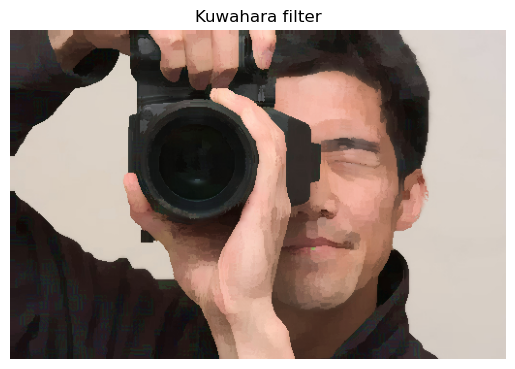

In [27]:
plt.imshow(result)
plt.axis('off')
plt.title("Kuwahara filter")
plt.show()